Imports

In [60]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern # this is the sucker we will be altering 
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import random
import scipy as sp
import scipy.interpolate
from scipy.interpolate import CubicSpline

Clean and read Raw Data

In [68]:
def CleanCassiano(fileName):
    with open(fileName, "r") as file:
        data = file.read()
    d = data.split(" ")
    for i in range(len(d)):
        if d[i] == '':
            d[i] = 999
    d.remove(999)
    d2 = [float(value) for value in d if value != 999]
    actualData = np.array(d2).reshape(1168,3)
    x = actualData[:,0]
    y = actualData[:,1]
    z = actualData[:,2]
    
    df = pd.DataFrame(
    {"y" : y,
    "x" : x,
    "z" : z})

    return(df)

In [69]:
def CleanCassianoAux(fileName):
    with open(fileName, "r") as file:
        data = file.read()
    d = data.replace("\t"," ")
    d = d.replace("\n"," ")
    d = d.split()
    d2 = [float(value) for value in d]
    actualData = np.array(d2).reshape(int(len(d2)/3),3)
    x = actualData[:,0]
    y = actualData[:,1]
    z = actualData[:,2]/100
    
    
    df = pd.DataFrame(
    {"y" : y,
    "x" : x,
    "z" : z})

    df.z = df.z.fillna(0)
    return(df)

def cokriging model

In [70]:
def cokriging_model(X_width, X_depth, y, X_pred_width, X_pred_depth):
    
    # Perform ordinary kriging on width variable
    if X_width.shape[0] > 0:
        kriging_width = GaussianProcessRegressor(kernel=Matern(length_scale_bounds = (1e-10,1e3), nu =1.5), normalize_y=True)
        kriging_width.fit(X_width, y)
        y_pred_width, y_pred_width_std = kriging_width.predict(X_pred_width, return_std=True)
    else:
        y_pred_width = np.zeros(X_pred_width.shape[0])
        y_pred_width_std = np.zeros(X_pred_width.shape[0])

    # Perform ordinary kriging on depth variable
    if X_depth.shape[0] > 0:
        kriging_depth = GaussianProcessRegressor(kernel=Matern(length_scale_bounds = (1e-150,1e3), nu = 1.5), normalize_y=True)
        kriging_depth.fit(X_depth, y)
        y_pred_depth, y_pred_depth_std = kriging_depth.predict(X_pred_depth, return_std=True)
    else:
        y_pred_depth = np.zeros(X_pred_depth.shape[0])
        y_pred_depth_std = np.zeros(X_pred_depth.shape[0])

    # Perform cokriging to combine predictions
    if X_width.shape[0] == 0:
        y_pred_cokriging = y_pred_depth
        y_pred_cokriging_std = y_pred_depth_std
    elif X_depth.shape[0] == 0:
        y_pred_cokriging = y_pred_width
        y_pred_cokriging_std = y_pred_width_std
    else:
        y_pred_cokriging = (y_pred_width + y_pred_depth) / 2.0
        y_pred_cokriging_std = np.sqrt((y_pred_width_std**2 + y_pred_depth_std**2) / 2.0)

    return y_pred_cokriging, y_pred_cokriging_std

plot raw data as 2d

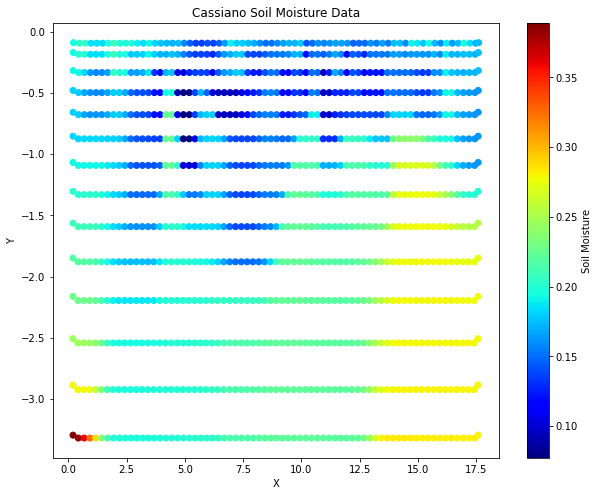

In [71]:
file_path = "Moisture_Content_All_Soils_Result (3).txt"

plt.figure(figsize = (10,8))
df = CleanCassiano(file_path)
df = df.dropna()

plt.scatter(df.x,df.y,c = df.z, cmap = "jet")
plt.title("Cassiano Soil Moisture Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Soil Moisture')
plt.show()

plot raw data as 3d

In [ ]:
x = df.x.to_numpy()
y = df.y.to_numpy()
z = df.z.to_numpy()
x_grid = np.linspace(1, 17, 10)
y_grid = np.linspace(-3.5, 0, 10)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy') # all x vals and all y vals

C:\Users\noelh\AppData\Local\Temp/ipykernel_9648/317412796.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


Text(0.5, 0.92, '3D soil moisture')

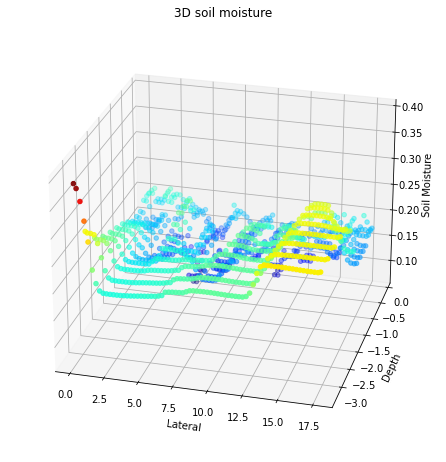

In [74]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.scatter3D(x,y,z, c=z,cmap = "jet")
ax.set_xlabel("Lateral")
ax.set_ylabel("Depth")
ax.set_zlabel("Soil Moisture")
ax.view_init(25, 80+180+45-20)
ax.set_title("3D soil moisture")

### Interpolating Time
Use Interpolating mesh

C:\Users\noelh\AppData\Local\Temp/ipykernel_9648/627176446.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


Text(0.5, 0.92, 'Cublic Spline Interpolant')

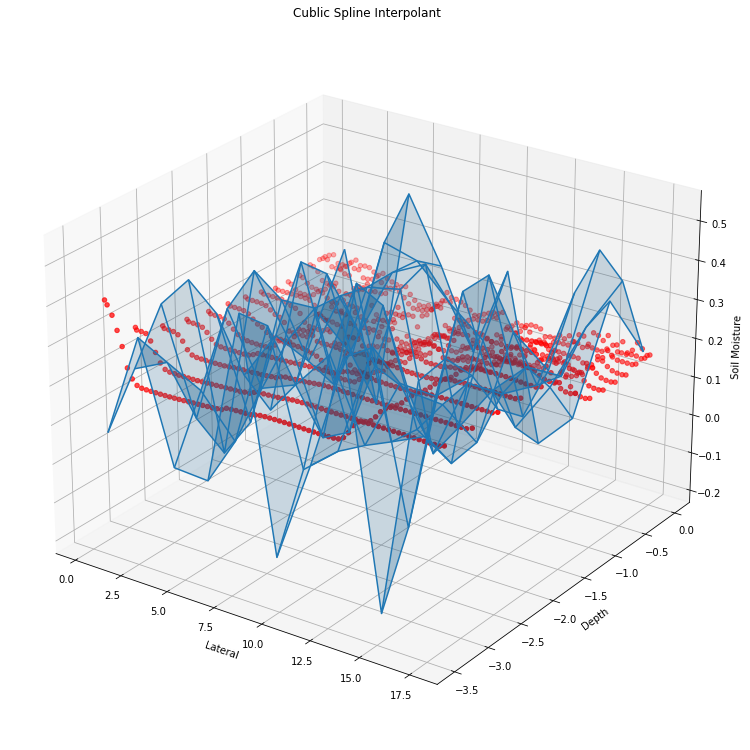

In [75]:

spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=5, episilon=5)

Z = spline(B1,B2)
fig = plt.figure(figsize=(10,10))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel("Lateral")
ax.set_ylabel("Depth")
ax.set_zlabel("Soil Moisture")
ax.view_init(25, 80+180+45)
ax.set_title("Cublic Spline Interpolant")

Tone down the sensitivity

C:\Users\noelh\AppData\Local\Temp/ipykernel_9648/3519068283.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


Text(0.5, 0.92, 'Adjusted Cublic Spline Interpolant')

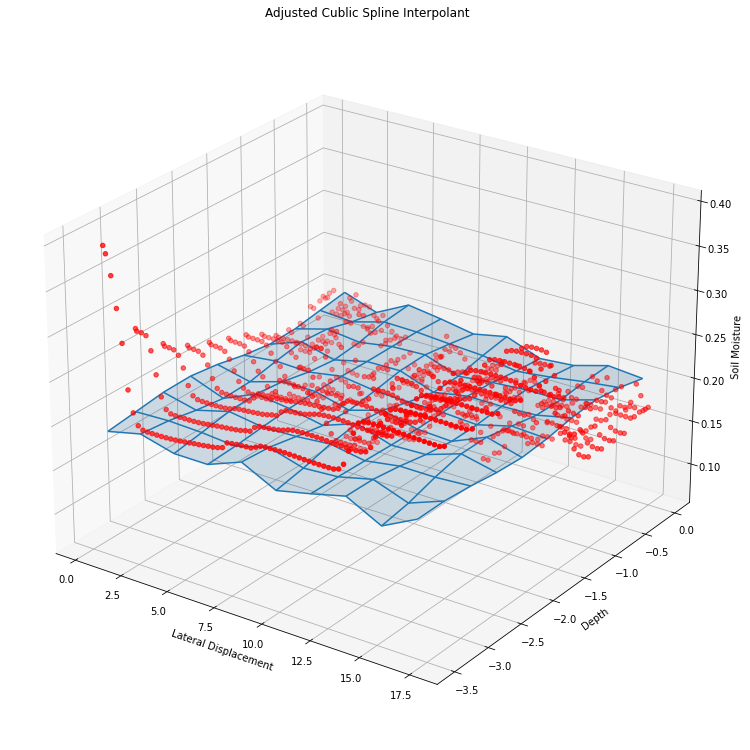

In [76]:

spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=5, episilon=5)

Z2 = 1/30 * spline(B1,B2) + np.mean(Z)
fig = plt.figure(figsize=(10,10))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z2)
ax.plot_surface(B1, B2, Z2,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel("Lateral Displacement")
ax.set_ylabel("Depth")
ax.set_zlabel("Soil Moisture")
ax.view_init(25, 80+180+45)
ax.set_title("Adjusted Cublic Spline Interpolant")

side view

C:\Users\noelh\AppData\Local\Temp/ipykernel_9648/3206640344.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


Text(0.5, 0.92, 'Adjusted Cublic Spline Interpolant')

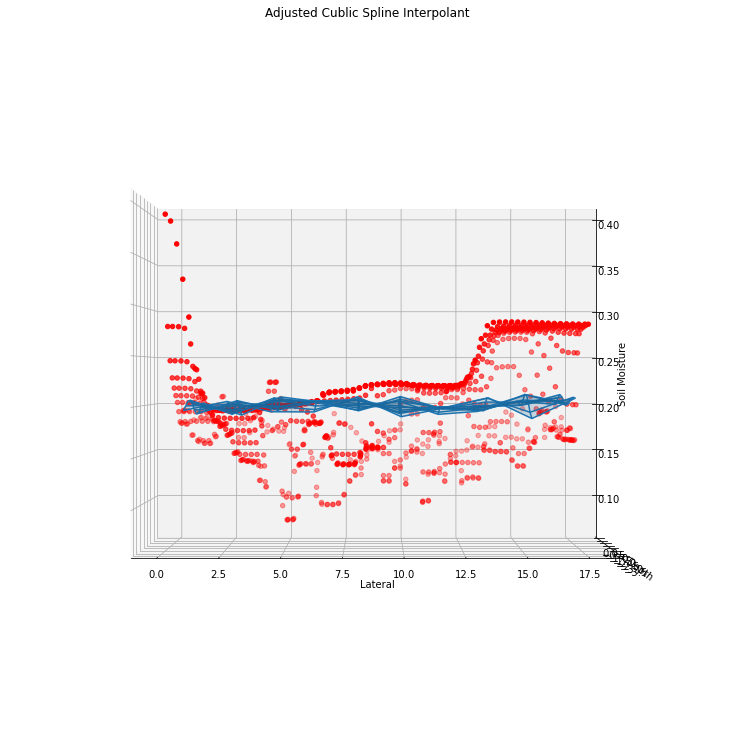

In [77]:
fig = plt.figure(figsize=(10,10))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z2)
ax.plot_surface(B1, B2, Z2,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel("Lateral")
ax.set_ylabel("Depth")
ax.set_zlabel("Soil Moisture")
ax.view_init(0, 80+180+10)
ax.set_title("Adjusted Cublic Spline Interpolant")

Interpolating with Cokriging Predictions

In [78]:
x_grid = np.linspace(1, 17, 10)
y_grid = np.linspace(-3.5, 0, 10)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy') # all x vals and all y val

C:\Users\noelh\anaconda32\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


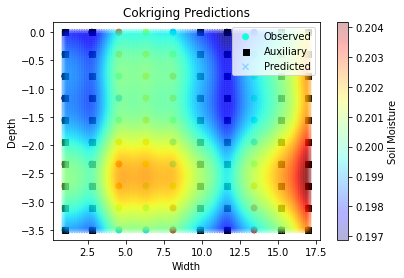

In [79]:
# Grid parameters
N_width = len(B1)  # Number of grid points in the width direction
M_depth = len(B2)  # Number of grid points in the depth direction

# Grid coordinates
X_width_observed, X_depth_observed = B1,B2
X_width_observed = X_width_observed.flatten()[:, np.newaxis]
X_depth_observed = X_depth_observed.flatten()[:, np.newaxis]

# Observed values
y_observed = Z2.flatten()
y_obs_matrix = y_observed.reshape((N_width * M_depth))

# Auxiliary data points
column_indices = [0,1,5,6,8,9]  # Change 
auxiliary_mask = np.isin(X_width_observed[:, 0], X_width_observed[column_indices, 0]) # check whether data is in other vector
X_width_auxiliary = X_width_observed[auxiliary_mask]
X_depth_auxiliary = X_depth_observed[auxiliary_mask]
y_auxiliary = y_observed[auxiliary_mask] # effectively selecting all the data that we are after with the mask index




# Predicted data 
N_predicted = 100 # Change
M_predicted = 100 # "

x_grid = np.linspace(1, 17, N_predicted)
y_grid = np.linspace(-3.5, 0, M_predicted)
C1, C2 = np.meshgrid(x_grid, y_grid, indexing='xy') # all x vals and all y vals


X_width_predicted, X_depth_predicted = C1,C2
X_width_predicted = X_width_predicted.flatten()[:, np.newaxis] # flattern to make the model work later 
X_depth_predicted = X_depth_predicted.flatten()[:, np.newaxis]

# Cokriging model
y_pred, y_pred_std = cokriging_model(
    np.concatenate([X_width_observed, X_width_auxiliary]),
    np.concatenate([X_depth_observed, X_depth_auxiliary]),
    np.concatenate([y_observed, y_auxiliary]),
    X_width_predicted,
    X_depth_predicted
)

# Plotting
plt.scatter(X_width_observed, X_depth_observed, c=y_observed, cmap='jet', label='Observed')
plt.scatter(X_width_auxiliary, X_depth_auxiliary, c="k", cmap='jet', marker='s', label='Auxiliary') # c=kfor ease
plt.scatter(X_width_predicted, X_depth_predicted, c=y_pred, cmap='jet', marker="x", label='Predicted', alpha = 0.3)
plt.colorbar(label='Soil Moisture')
plt.xlabel('Width')
plt.ylabel('Depth')
plt.legend()
plt.title('Cokriging Predictions')
plt.show()

 ##### Now replace cubic spline with N Dimenstional Interpolator

C:\Users\noelh\AppData\Local\Temp/ipykernel_9648/2584563182.py:24: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(xi, yi, zi)


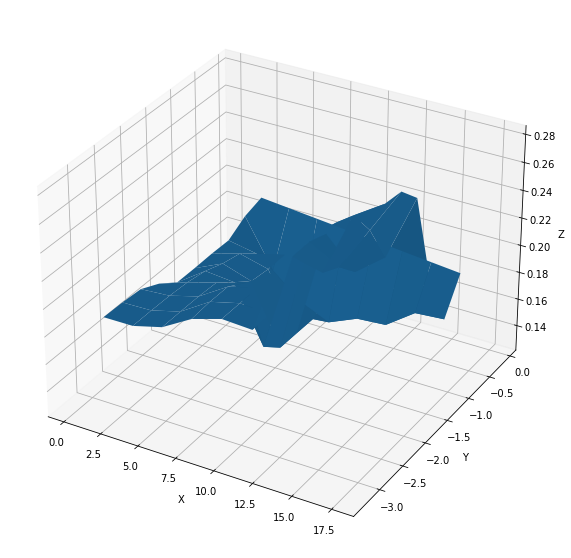

In [80]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator

# Generate sample data for the surface
x = df.x.values  # Sample x coordinates
y = df.y.values  # Sample y coordinates
z = df.z.values  # Sample z values

# Create the linear interpolator
interp = LinearNDInterpolator((x, y), z)

# Define the grid points for the interpolated surface
xi = np.linspace(min(x), max(x), 10)  # Grid points for x
yi = np.linspace(min(y), max(y), 10)  # Grid points for y
xi, yi = np.meshgrid(xi, yi)  # Create a meshgrid from xi and yi

# Perform the interpolation
zi = interp(xi, yi)

# Plot the interpolated surface
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


###### implement new auxiliary data

#### New Auxiliary Data
view new raw data as 2d

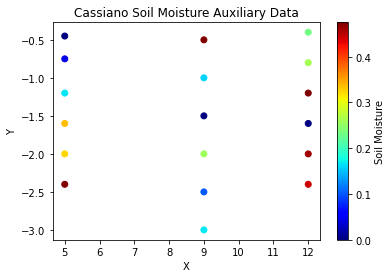

In [81]:
file_path_5 = "Moisture_5m.txt"
file_path_9 = "Moisture_9m.txt"
file_path_12 = "Moisture_12m.txt"
auxLst = [file_path_5,file_path_9,file_path_12 ]
for i in range(len(auxLst)):
    df = CleanCassianoAux(auxLst[i])
    df.z = df.z.fillna(1)
    plt.scatter(df.x,df.y,c =  df.z, cmap = "jet" )

plt.title("Cassiano Soil Moisture Auxiliary Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Soil Moisture')
plt.show()


Interpolate the new params

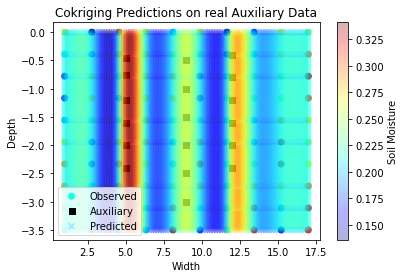

In [82]:
# Grid parameters
N_width = len(B1)  # Number of grid points in the width direction
M_depth = len(B2)  # Number of grid points in the depth direction

# Grid coordinates
X_width_observed, X_depth_observed = B1,B2
X_width_observed = X_width_observed.flatten()[:, np.newaxis]
X_depth_observed = X_depth_observed.flatten()[:, np.newaxis]

# Observed values
y_observed = Z2.flatten()
y_obs_matrix = y_observed.reshape((N_width * M_depth))

# Auxiliary data points
file_path_5 = "Moisture_5m.txt"
file_path_9 = "Moisture_9m.txt"
file_path_12 = "Moisture_12m.txt"
auxLst = [file_path_5,file_path_9,file_path_12 ]
for i in range(len(auxLst)):
    if i == 0:
        df = CleanCassianoAux(auxLst[i])
    if i > 0:
        df2 = CleanCassianoAux(auxLst[i])
        df = pd.concat([df,df2])
    
y_auxiliary  = df.z.values
X_width_auxiliary = df.x.values[:, np.newaxis]
X_depth_auxiliary = df.y.values[:, np.newaxis]

# column_indices = [0,1,5,6,8,9]  # Change 
# auxiliary_mask = np.isin(X_width_observed[:, 0], X_width_observed[column_indices, 0]) # check whether data is in other vector
# X_width_auxiliary = X_width_observed[auxiliary_mask]
# X_depth_auxiliary = X_depth_observed[auxiliary_mask]
# y_auxiliary = y_observed[auxiliary_mask] # effectively selecting all the data that we are after with the mask index


# Predicted data 
N_predicted = 100 # Change
M_predicted = 100 # "

x_grid = np.linspace(1, 17, N_predicted)
y_grid = np.linspace(-3.5, 0, M_predicted)
C1, C2 = np.meshgrid(x_grid, y_grid, indexing='xy') # all x vals and all y vals


X_width_predicted, X_depth_predicted = C1,C2
X_width_predicted = X_width_predicted.flatten()[:, np.newaxis] # flattern to make the model work later 
X_depth_predicted = X_depth_predicted.flatten()[:, np.newaxis]

# Cokriging model
y_pred, y_pred_std = cokriging_model(
    np.concatenate([X_width_observed, X_width_auxiliary]),
    np.concatenate([X_depth_observed, X_depth_auxiliary]),
    np.concatenate([y_observed, y_auxiliary]),
    X_width_predicted,
    X_depth_predicted
)

# Plotting
plt.scatter(X_width_observed, X_depth_observed, c=y_observed, cmap='jet', label='Observed')
plt.scatter(X_width_auxiliary, X_depth_auxiliary, c="k", cmap='jet', marker='s', label='Auxiliary') # c=kfor ease
plt.scatter(X_width_predicted, X_depth_predicted, c=y_pred, cmap='jet', marker="x", label='Predicted', alpha = 0.3)
plt.colorbar(label='Soil Moisture')
plt.xlabel('Width')
plt.ylabel('Depth')
plt.legend()
plt.title('Cokriging Predictions on real Auxiliary Data')
plt.show()